In [33]:
import pandas as pd
import numpy as np
import os
import cv2
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from scipy.special import softmax

In [34]:
def generate_extended_array_with_key_points(array_to_extend, new_size_of_array, ratio):
    expanded_numpy = np.full(shape=(new_size_of_array, array_to_extend.shape[1]), fill_value=np.nan)
    int_part=ratio//1
    float_part=ratio%1
    idx_expanded_array=0
    idx_array_to_extend=0
    residual=0
    while idx_array_to_extend<array_to_extend.shape[0]:
        expanded_numpy[idx_expanded_array]=array_to_extend[idx_array_to_extend]
        residual+=float_part
        idx_to_add=int(int_part)
        if residual>=1:
            idx_to_add+=1
            residual-=1
        idx_expanded_array+=idx_to_add
        idx_array_to_extend+=1
    return expanded_numpy

def construct_video_filename_from_label(path_to_video, label_filename):
    """This function generate video filename from label filename
       It is inner function for processing specific data from AffWild2 challenge
       It is needed, because video can be in either mp4 or avi format

    :param path_to_video: string, path to directory with videos
    :param label_filename: string, filename of labels
    :return: string, video filename (e. g. 405.mp4)
    """
    video_filename = label_filename.split('_left')[0].split('_right')[0].split('_vocals')[0].split('.')[0]
    if os.path.exists(path_to_video + video_filename + '.mp4'):
        video_filename += '.mp4'
    if os.path.exists(path_to_video + video_filename + '.avi'):
        video_filename += '.avi'
    return video_filename

def get_video_frame_rate(path_to_video):
    """The function reads params of video to get video frame rate

    :param path_to_video: string, path to certain video
    :return: int, video frame rate
    """
    cap = cv2.VideoCapture(path_to_video)
    video_frame_rate = cap.get(cv2.CAP_PROP_FPS)
    return video_frame_rate

def extend_sample_rate_of_labels(labels, original_sample_rate, needed_sample_rate):
    """This function extends sample rate of provided labels from original_sample_rate to needed_sample_rate
       by stretching existing labels with calculated ratio

    :param labels: ndarray (n_labels,) or DataFrame (n_labels, 1)
    :param original_sample_rate: int, sample rate of provided labels
    :param needed_sample_rate:int
    :return: ndarray, stretched labels with new sample_rate
    """
    # calculate ration between original and needed sample rates
    ratio=needed_sample_rate/original_sample_rate
    new_size_of_labels=int(math.ceil(labels.shape[0]*ratio))
    # calculating key_points - positions, which will be used as indexes for provided labels_filenames
    # e.g.
    # we have labels [1 1 1 2 2 1] with sample rate=2 and we need sample rate 6 (ratio=3)
    # then key_points will be
    # [0 3 6 9 12 15] ---> [1 _ _ 1 _ _ 1 _ _ 2 _ _ 2 _ _ 1 _ _]
    # old shape=6 ---> new shape = 18
    expanded_numpy_with_nan=generate_extended_array_with_key_points(array_to_extend=labels.values, new_size_of_array=new_size_of_labels, ratio=ratio)
    new_labels=pd.DataFrame(columns=labels.columns,data=expanded_numpy_with_nan).interpolate()
    return new_labels

def align_sample_rate_to_video_rate(predictions, path_to_video, filename, original_sample_rate):
    video_filename = construct_video_filename_from_label(path_to_video=path_to_video,
                                                         label_filename=filename)
    video_frame_rate = get_video_frame_rate(path_to_video + video_filename)

    predictions = extend_sample_rate_of_labels(predictions, original_sample_rate, video_frame_rate)
    predictions = predictions.astype('float32')

    # align to video amount of frames
    cap = cv2.VideoCapture(path_to_video + video_filename)
    video_frame_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    aligned_predictions = np.zeros(shape=(video_frame_length, predictions.shape[1]), dtype='float32')
    predictions = predictions.values
    if video_frame_length <= predictions.shape[0]:
        aligned_predictions[:] = predictions[:video_frame_length]
    else:
        aligned_predictions[:predictions.shape[0]] = predictions[:]
        value_to_fill = predictions[-1]
        aligned_predictions[predictions.shape[0]:] = value_to_fill
    aligned_predictions = pd.DataFrame(data=aligned_predictions)
    return aligned_predictions

In [37]:
path_to_model_3_predictions = 'C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\Pretrained_AffectNet_model_3\\test'
path_to_model_4_predictions = 'C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\Pretrained_AffectNet_model_4\\test'
path_to_1D_CNN_predictions = 'C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\1D_CNN\\test'
path_to_PANN_predictions = 'C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\PANN\\test'
path_to_linearSVM_predictions_train_power = 'C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\linearSVM_4_2_z_power_l2_C_0_01\\test\\trained_only_train'
path_to_linearSVM_predictions_train_dev_power = 'C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\linearSVM_4_2_z_power_l2_C_0_01\\test\\trained_train_dev'
path_to_linearSVM_predictions_train_z_l2 = 'C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\linearSVM_4_2_z_l2_C_0_1\\test\\trained_only_train'
path_to_linearSVM_predictions_train_dev_z_l2 = 'C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\linearSVM_4_2_z_l2_C_0_1\\test\\trained_train_dev'
path_to_submission_9_predictions='C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\predictions_for_submission\\Elena_AffectNet_3_4_and_1DCNN_submission_9\\test_predictions'


path_to_fused_model_3_4_1D_CNN_SVM_train_power='C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\predictions_for_submission\\Elena_AffectNet_3_4_and_1DCNN_LinearSVM_4_2_z_power_l2_C_0_01\\test_predictions_trained_only_train'
path_to_fused_model_3_4_1D_CNN_SVM_train_dev_power='C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\predictions_for_submission\\Elena_AffectNet_3_4_and_1DCNN_LinearSVM_4_2_z_power_l2_C_0_01\\test_predictions_trained_train_dev'
path_to_fused_model_3_4_1D_CNN_SVM_train_z_l2='C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\predictions_for_submission\\Elena_AffectNet_3_4_and_1DCNN_LinearSVM_4_2_z_l2_C_0_1\\test_predictions_trained_only_train'
path_to_fused_model_3_4_1D_CNN_SVM_train_dev_z_l2='C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\predictions_for_submission\\Elena_AffectNet_3_4_and_1DCNN_LinearSVM_4_2_z_l2_C_0_1\\test_predictions_trained_train_dev'


path_to_videos='E:\\Databases\\AffWild2\\Videos\\'
path_to_fusion_weights='C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\predictions_for_submission\\' \
                       'Elena_AffectNet_3_4_and_1DCNN_submission_9\\weights_for_fusion.txt'
num_classes = 7

# load all filenames with predictions
labels_filenames = os.listdir(path_to_model_3_predictions)
# create variables to load predictions
model_3_predictions = []
model_4_predictions = []
model_1D_predictions = []
model_PANN_predictions =[]
model_linearSVM_predictions_train_power=[]
model_linearSVM_predictions_train_dev_power=[]
model_linearSVM_predictions_train_z_l2=[]
model_linearSVM_predictions_train_dev_z_l2=[]
submission_9_predictions=[]
model_fused_SVM_predictions_train_power=[]
model_fused_SVM_predictions_train_dev_power=[]
model_fused_SVM_predictions_train_z_l2=[]
model_fused_SVM_predictions_train_dev_z_l2=[]

for lbs_filename in labels_filenames:
    filename = lbs_filename.split('.')[0]

    model_3_pred = pd.read_csv(os.path.join(path_to_model_3_predictions, filename + '.txt'))
    model_3_pred = pd.DataFrame(data=model_3_pred.iloc[:, 1:].values)

    model_4_pred = pd.read_csv(os.path.join(path_to_model_4_predictions, filename + '.txt'))
    model_4_pred = pd.DataFrame(data=model_4_pred.iloc[:, 1:].values)

    model_PANN_pred = pd.read_csv(os.path.join(path_to_PANN_predictions, filename + '.csv'), header=None)
    model_PANN_pred = align_sample_rate_to_video_rate(model_PANN_pred, path_to_videos, filename, 5)

    model_1D_pred = pd.read_csv(os.path.join(path_to_1D_CNN_predictions, filename + '.csv'), header=None)
    model_1D_pred = align_sample_rate_to_video_rate(model_1D_pred, path_to_videos, filename, 5)

    model_linearSVM_train_power_pred = pd.read_csv(os.path.join(path_to_linearSVM_predictions_train_power, filename + '.csv'))
    model_linearSVM_train_power_pred.iloc[:]=softmax(model_linearSVM_train_power_pred.iloc[:], axis=1)
    model_linearSVM_train_power_pred = pd.DataFrame(data=model_linearSVM_train_power_pred.values)
    
    model_linearSVM_train_dev_power_pred = pd.read_csv(os.path.join(path_to_linearSVM_predictions_train_dev_power, filename + '.csv'))
    model_linearSVM_train_dev_power_pred.iloc[:]=softmax(model_linearSVM_train_dev_power_pred.iloc[:], axis=1)
    model_linearSVM_train_dev_power_pred = pd.DataFrame(data=model_linearSVM_train_dev_power_pred.values)
    
    model_linearSVM_train_z_l2_pred = pd.read_csv(os.path.join(path_to_linearSVM_predictions_train_z_l2, filename + '.csv'))
    model_linearSVM_train_z_l2_pred.iloc[:]=softmax(model_linearSVM_train_z_l2_pred.iloc[:], axis=1)
    model_linearSVM_train_z_l2_pred = pd.DataFrame(data=model_linearSVM_train_z_l2_pred.values)
    
    model_linearSVM_train_dev_z_l2_pred = pd.read_csv(os.path.join(path_to_linearSVM_predictions_train_dev_z_l2, filename + '.csv'))
    model_linearSVM_train_dev_z_l2_pred.iloc[:]=softmax(model_linearSVM_train_dev_z_l2_pred.iloc[:], axis=1)
    model_linearSVM_train_dev_z_l2_pred = pd.DataFrame(data=model_linearSVM_train_dev_z_l2_pred.values)
    
    submission_9_pred=pd.read_csv(os.path.join(path_to_submission_9_predictions, filename + '.txt'), header=None, skiprows=1)
    
    model_fused_SVM_train_power_pred=pd.read_csv(os.path.join(path_to_fused_model_3_4_1D_CNN_SVM_train_power, filename + '.txt'), header=None, skiprows=1)
    
    model_fused_SVM_train_dev_power_pred=pd.read_csv(os.path.join(path_to_fused_model_3_4_1D_CNN_SVM_train_dev_power, filename + '.txt'), header=None, skiprows=1)
    
    model_fused_SVM_train_z_l2_pred=pd.read_csv(os.path.join(path_to_fused_model_3_4_1D_CNN_SVM_train_z_l2, filename + '.txt'), header=None, skiprows=1)
    
    model_fused_SVM_train_dev_z_l2_pred=pd.read_csv(os.path.join(path_to_fused_model_3_4_1D_CNN_SVM_train_dev_z_l2, filename + '.txt'), header=None, skiprows=1)
    
      

    # append to the lists created above for former concatenation
    model_3_predictions.append(model_3_pred)
    model_4_predictions.append(model_4_pred)
    model_PANN_predictions.append(model_PANN_pred)
    model_1D_predictions.append(model_1D_pred)
    model_linearSVM_predictions_train_power.append(model_linearSVM_train_power_pred)
    model_linearSVM_predictions_train_dev_power.append(model_linearSVM_train_dev_power_pred)
    model_linearSVM_predictions_train_z_l2.append(model_linearSVM_train_z_l2_pred)
    model_linearSVM_predictions_train_dev_z_l2.append(model_linearSVM_train_dev_z_l2_pred)
    submission_9_predictions.append(submission_9_pred)
    model_fused_SVM_predictions_train_power.append(model_fused_SVM_train_power_pred)
    model_fused_SVM_predictions_train_dev_power.append(model_fused_SVM_train_dev_power_pred)
    model_fused_SVM_predictions_train_z_l2.append(model_fused_SVM_train_z_l2_pred)
    model_fused_SVM_predictions_train_dev_z_l2.append(model_fused_SVM_train_dev_z_l2_pred)

    
    
# concatenate all loaded predictions
model_3_predictions=pd.concat(model_3_predictions)
model_4_predictions = pd.concat(model_4_predictions)
model_PANN_predictions = pd.concat(model_PANN_predictions)
model_1D_predictions = pd.concat(model_1D_predictions)
model_linearSVM_predictions_train_power=pd.concat(model_linearSVM_predictions_train_power)
model_linearSVM_predictions_train_dev_power=pd.concat(model_linearSVM_predictions_train_dev_power)
model_linearSVM_predictions_train_z_l2=pd.concat(model_linearSVM_predictions_train_z_l2)
model_linearSVM_predictions_train_dev_z_l2=pd.concat(model_linearSVM_predictions_train_dev_z_l2)
submission_9_predictions=pd.concat(submission_9_predictions)
model_fused_SVM_predictions_train_power=pd.concat(model_fused_SVM_predictions_train_power)
model_fused_SVM_predictions_train_dev_power=pd.concat(model_fused_SVM_predictions_train_dev_power)
model_fused_SVM_predictions_train_z_l2=pd.concat(model_fused_SVM_predictions_train_z_l2)
model_fused_SVM_predictions_train_dev_z_l2=pd.concat(model_fused_SVM_predictions_train_dev_z_l2)

model_3_predictions=np.argmax(model_3_predictions.values, axis=-1)[...,np.newaxis]
model_4_predictions = np.argmax(model_4_predictions.values, axis=-1)[...,np.newaxis]
model_PANN_predictions =np.argmax(model_PANN_predictions.values, axis=-1)[...,np.newaxis]
model_1D_predictions =np.argmax(model_1D_predictions.values, axis=-1)[...,np.newaxis]
model_linearSVM_predictions_train_power=np.argmax(model_linearSVM_predictions_train_power.values, axis=-1)[...,np.newaxis]
model_linearSVM_predictions_train_dev_power=np.argmax(model_linearSVM_predictions_train_dev_power.values, axis=-1)[...,np.newaxis]
model_linearSVM_predictions_train_z_l2=np.argmax(model_linearSVM_predictions_train_z_l2.values, axis=-1)[...,np.newaxis]
model_linearSVM_predictions_train_dev_z_l2=np.argmax(model_linearSVM_predictions_train_dev_z_l2.values, axis=-1)[...,np.newaxis]




In [49]:
path_to_ground_truth_validation='E:\\Databases\\AffWild2\\Annotations\\EXPR_Set\\validation\\Aligned_labels\\'

val_filenames=os.listdir(path_to_ground_truth_validation)
gt_validation=[]
for filename in val_filenames:
    gt_validation_pred=pd.read_csv(os.path.join(path_to_ground_truth_validation, filename), header=None)
    gt_validation.append(gt_validation_pred) 
gt_validation=pd.concat(gt_validation)

In [51]:
gt_validation.columns=['label']
gt_validation_distribution=gt_validation['label'].value_counts().sort_index()
gt_validation_distribution=gt_validation_distribution[gt_validation_distribution.index!=-1]
gt_validation_distribution.index=['Neutral','Anger','Disgust','Fear','Happiness','Sadness','Surprise']
gt_validation_distribution=gt_validation_distribution.reset_index()

(454356, 1)

In [38]:
class_mapping={
    0:'Neutral',
    1:'Anger',
    2:'Disgust',
    3:'Fear',
    4:'Happiness',
    5:'Sadness',
    6:'Surprise'
}

In [39]:
model_fused_SVM_predictions_train_dev_z_l2.shape

(1012161, 1)

In [42]:
concatenated_data=np.concatenate([model_3_predictions, model_4_predictions, model_PANN_predictions, model_1D_predictions,
                                  model_linearSVM_predictions_train_power,model_linearSVM_predictions_train_dev_power,
                                 model_linearSVM_predictions_train_z_l2,model_linearSVM_predictions_train_dev_z_l2, submission_9_predictions,
                                 model_fused_SVM_predictions_train_power,model_fused_SVM_predictions_train_dev_power,
                                 model_fused_SVM_predictions_train_z_l2,model_fused_SVM_predictions_train_dev_z_l2 ], axis=1)
df=pd.DataFrame(data=concatenated_data, columns=['model_3','model_4','PANN','model_1D',
                                                 'linearSVM_power_only_train','linearSVM_power_train_dev',
                                                'linearSVM_z_l2_only_train','linearSVM_z_l2_dev_train','submission_9','fused_SVM_train_power', 'fused_SVM_train_dev_power',
                                                'fused_SVM_train_z_l2', 'fused_SVM_train_dev_z_l2'])
model_3_distribution=pd.DataFrame(df['model_3'].value_counts().sort_index())
model_4_distribution = pd.DataFrame(df['model_4'].value_counts().sort_index())
model_PANN_distribution =pd.DataFrame(df['PANN'].value_counts().sort_index())
model_1D_distribution =pd.DataFrame(df['model_1D'].value_counts().sort_index())
model_linearSVM_distribution_train_power_distribution=pd.DataFrame(df['linearSVM_power_only_train'].value_counts().sort_index())
model_linearSVM_distribution_train_dev_power_distribution=pd.DataFrame(df['linearSVM_power_train_dev'].value_counts().sort_index())
model_linearSVM_distribution_train_z_l2_distribution=pd.DataFrame(df['linearSVM_z_l2_only_train'].value_counts().sort_index())
model_linearSVM_distribution_train_dev_z_l2_distribution=pd.DataFrame(df['linearSVM_z_l2_dev_train'].value_counts().sort_index())
submission_9_distribution=pd.DataFrame(df['submission_9'].value_counts().sort_index())
model_fused_SVM_predictions_train_power_distribution=pd.DataFrame(df['fused_SVM_train_power'].value_counts().sort_index())
model_fused_SVM_predictions_train_dev_power_distribution=pd.DataFrame(df['fused_SVM_train_dev_power'].value_counts().sort_index())
model_fused_SVM_predictions_train_z_l2_distribution=pd.DataFrame(df['fused_SVM_train_z_l2'].value_counts().sort_index())
model_fused_SVM_predictions_train_dev_z_l2_distribution=pd.DataFrame(df['fused_SVM_train_dev_z_l2'].value_counts().sort_index())
#gt_validation_distribution=pd.DataFrame(data=gt_validation, columns=['label'])['label'].value_counts().sort_index()



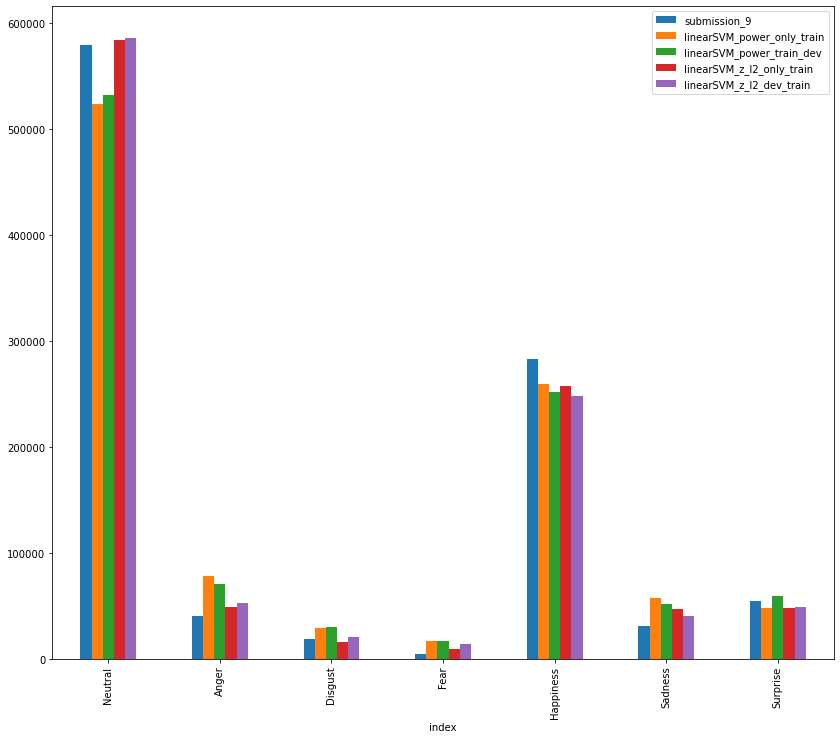

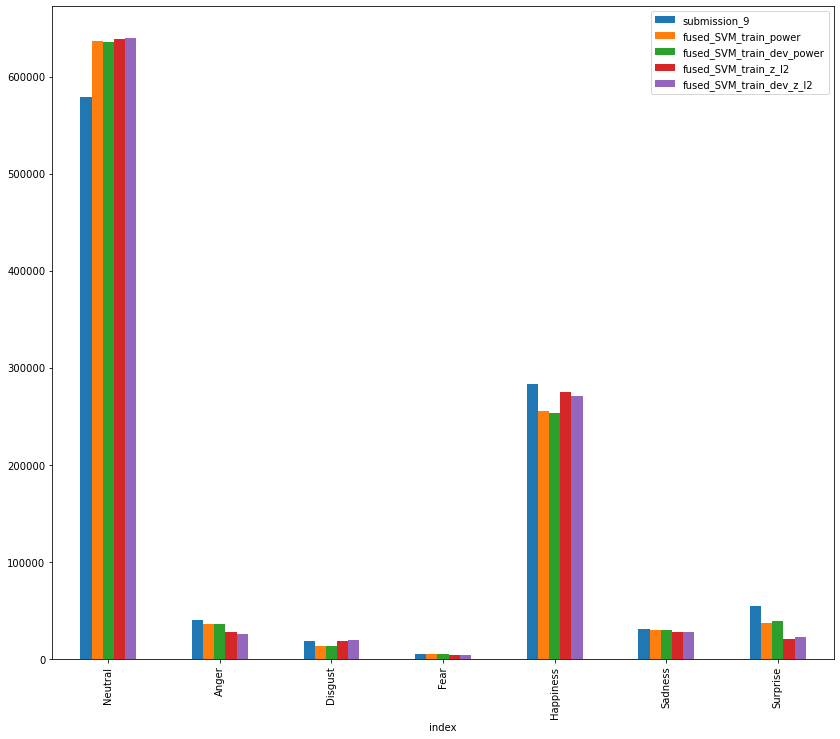

In [52]:
all_models_distributions=pd.concat([model_3_distribution,model_4_distribution,model_PANN_distribution,model_1D_distribution,
                                    model_linearSVM_distribution_train_power_distribution,model_linearSVM_distribution_train_dev_power_distribution,
                                    model_linearSVM_distribution_train_z_l2_distribution,model_linearSVM_distribution_train_dev_z_l2_distribution, submission_9_distribution,
                                    model_fused_SVM_predictions_train_power_distribution,model_fused_SVM_predictions_train_dev_power_distribution,
                                    model_fused_SVM_predictions_train_z_l2_distribution,model_fused_SVM_predictions_train_dev_z_l2_distribution ], axis=1)
all_models_distributions.index=['Neutral','Anger','Disgust','Fear','Happiness','Sadness','Surprise']
all_models_distributions=all_models_distributions.reset_index()


all_models_distributions.plot(x="index", y=['submission_9','linearSVM_power_only_train','linearSVM_power_train_dev',
                                                'linearSVM_z_l2_only_train','linearSVM_z_l2_dev_train'], kind="bar",figsize=(14,12))

all_models_distributions.plot(x="index", y=['submission_9','fused_SVM_train_power','fused_SVM_train_dev_power',
                                                'fused_SVM_train_z_l2','fused_SVM_train_dev_z_l2'], kind="bar",figsize=(14,12)).get_figure().savefig('distribution.png')
plt.show()

,index,label
0,Neutral,183636
1,Anger,8002
2,Disgust,5825
3,Fear,9754
4,Happiness,53702
5,Sadness,39486
6,Surprise,23113


In [72]:
all_models_distributions_normalized=all_models_distributions.copy()
num_instances=all_models_distributions.iloc[:,1:].sum(axis=0)[0]
num_instances
all_models_distributions_normalized.iloc[:,1:]/=num_instances

In [73]:
all_models_distributions_normalized

,index,model_3,model_4,PANN,model_1D,linearSVM_power_only_train,linearSVM_power_train_dev,linearSVM_z_l2_only_train,linearSVM_z_l2_dev_train,submission_9,fused_SVM_train_power,fused_SVM_train_dev_power,fused_SVM_train_z_l2,fused_SVM_train_dev_z_l2
0,Neutral,0.327831,0.575167,0.740246,0.813120,0.517744,0.526129,0.577553,0.579406,0.572112,0.629167,0.628435,0.631174,0.632723
1,Anger,0.132561,0.036066,0.009720,0.025732,0.077628,0.069468,0.048333,0.052093,0.039939,0.035800,0.035172,0.026874,0.025764
2,Disgust,0.058778,0.005870,0.002382,0.010562,0.028858,0.029764,0.015926,0.020604,0.018309,0.012652,0.012952,0.018534,0.019115
3,Fear,0.028111,0.003750,0.002900,0.000673,0.016541,0.016420,0.009097,0.013787,0.004838,0.004744,0.004688,0.004143,0.004249
4,Happiness,0.273586,0.321629,0.174916,0.081934,0.255941,0.248530,0.254755,0.245490,0.280008,0.252613,0.250743,0.271238,0.268159
5,Sadness,0.047567,0.025586,0.056370,0.062433,0.056276,0.051432,0.046595,0.040076,0.030640,0.029071,0.029339,0.027410,0.027535
6,Surprise,0.131566,0.031932,0.013466,0.005548,0.047012,0.058258,0.047739,0.048545,0.054153,0.035953,0.038671,0.020627,0.022455


In [69]:
all_models_distributions_normalized

,index,model_3,model_4,PANN,model_1D,linearSVM_power_only_train,linearSVM_power_train_dev,linearSVM_z_l2_only_train,linearSVM_z_l2_dev_train,submission_9,fused_SVM_train_power,fused_SVM_train_dev_power,fused_SVM_train_z_l2,fused_SVM_train_dev_z_l2
0,Neutral,0.042296,0.074207,0.095506,0.104908,0.066799,0.067881,0.074515,0.074754,0.073813,0.081174,0.081080,0.081433,0.081633
1,Anger,0.017103,0.004653,0.001254,0.003320,0.010015,0.008963,0.006236,0.006721,0.005153,0.004619,0.004538,0.003467,0.003324
2,Disgust,0.007583,0.000757,0.000307,0.001363,0.003723,0.003840,0.002055,0.002658,0.002362,0.001632,0.001671,0.002391,0.002466
3,Fear,0.003627,0.000484,0.000374,0.000087,0.002134,0.002119,0.001174,0.001779,0.000624,0.000612,0.000605,0.000534,0.000548
4,Happiness,0.035298,0.041496,0.022567,0.010571,0.033021,0.032065,0.032868,0.031673,0.036126,0.032592,0.032351,0.034995,0.034598
5,Sadness,0.006137,0.003301,0.007273,0.008055,0.007261,0.006636,0.006012,0.005171,0.003953,0.003751,0.003785,0.003536,0.003553
6,Surprise,0.016974,0.004120,0.001737,0.000716,0.006065,0.007516,0.006159,0.006263,0.006987,0.004639,0.004989,0.002661,0.002897


In [29]:
all_models_distributions_normalized.iloc[:,1:]=all_models_distributions.iloc[:,1:]/all_models_distributions.iloc[:,1:].sum(axis=1).values.reshape((-1,1))

In [30]:
all_models_distributions_normalized.iloc[:,1:]

,model_3,model_4,PANN,model_1D,linearSVM_power_only_train,linearSVM_power_train_dev,linearSVM_z_l2_only_train,linearSVM_z_l2_dev_train,submission_9,fused_SVM_train_power,fused_SVM_train_dev_power,fused_SVM_train_z_l2,fused_SVM_train_dev_z_l2
0,0.042296,0.074207,0.095506,0.104908,0.066799,0.067881,0.074515,0.074754,0.073813,0.081174,0.081080,0.081433,0.081633
1,0.215494,0.058630,0.015801,0.041831,0.126194,0.112929,0.078571,0.084683,0.064926,0.058197,0.057177,0.043687,0.041882
2,0.231131,0.023081,0.009367,0.041531,0.113478,0.117040,0.062627,0.081022,0.071997,0.049752,0.050933,0.072879,0.075163
3,0.246714,0.032915,0.025449,0.005905,0.145169,0.144111,0.079842,0.121003,0.042462,0.041638,0.041144,0.036357,0.037294
4,0.086046,0.101156,0.055013,0.025769,0.080496,0.078165,0.080123,0.077209,0.088065,0.079450,0.078861,0.085307,0.084339
5,0.089692,0.048245,0.106293,0.117724,0.106114,0.096980,0.087861,0.075567,0.057776,0.054818,0.055323,0.051684,0.051921
6,0.236662,0.057439,0.024223,0.009979,0.084566,0.104794,0.085874,0.087322,0.097412,0.064672,0.069561,0.037104,0.040392


<AxesSubplot:xlabel='index'>

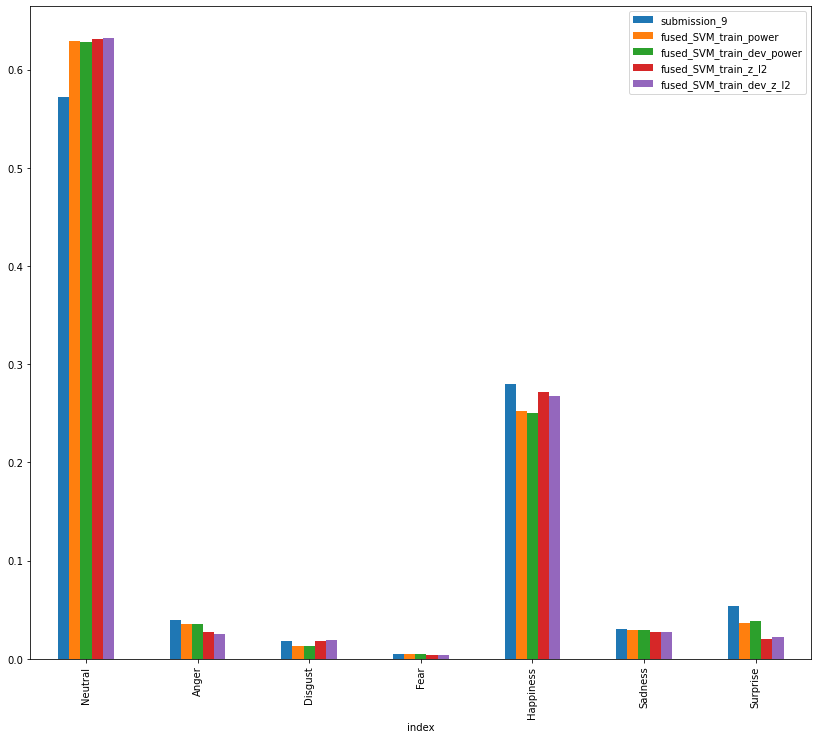

In [74]:
all_models_distributions_normalized.plot(x="index", y=['submission_9','fused_SVM_train_power','fused_SVM_train_dev_power',
                                                'fused_SVM_train_z_l2','fused_SVM_train_dev_z_l2'], kind="bar",figsize=(14,12))

<AxesSubplot:xlabel='index'>

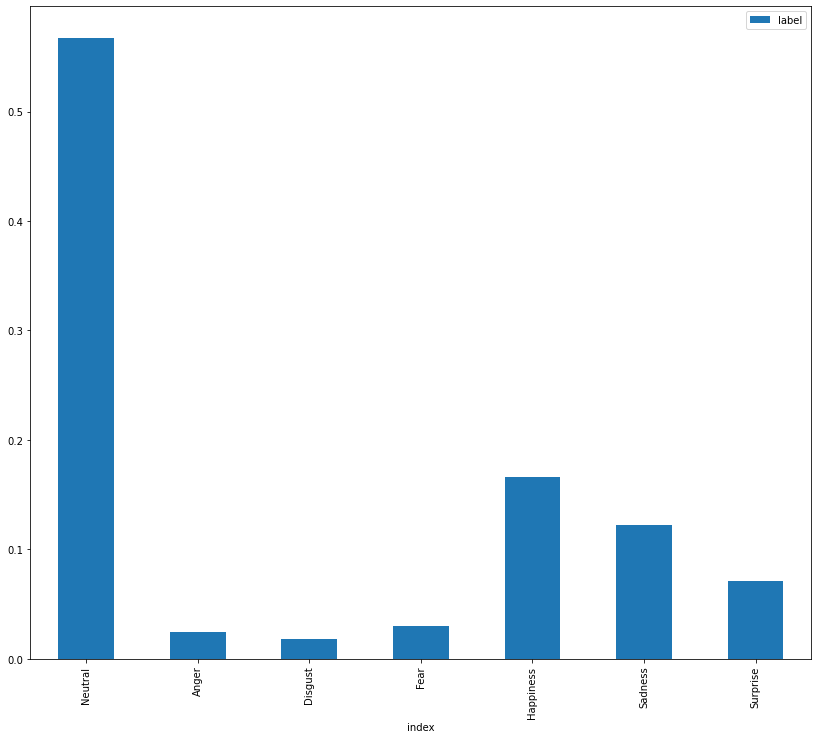

In [78]:
gt_validation_distribution=gt_validation_distribution.copy()
gt_validation_distribution.iloc[:,1:]/=gt_validation_distribution.iloc[:,1:].sum()
gt_validation_distribution.plot(x="index", y=['label'], kind="bar",figsize=(14,12))

<AxesSubplot:xlabel='index'>

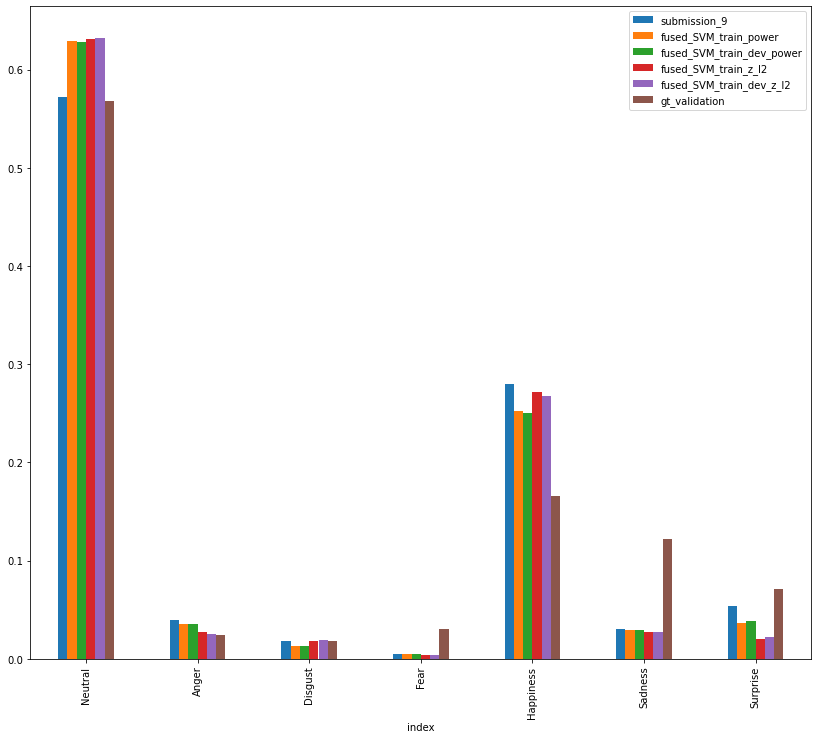

In [81]:
final_df=pd.concat([all_models_distributions_normalized, gt_validation_distribution], axis=1)
final_df.columns=['index','model_3','model_4','PANN','model_1D',
                                                 'linearSVM_power_only_train','linearSVM_power_train_dev',
                                                'linearSVM_z_l2_only_train','linearSVM_z_l2_dev_train','submission_9','fused_SVM_train_power', 'fused_SVM_train_dev_power',
                                                'fused_SVM_train_z_l2', 'fused_SVM_train_dev_z_l2','garbage','gt_validation']
final_df.plot(x="index", y=['submission_9','fused_SVM_train_power','fused_SVM_train_dev_power',
                                                'fused_SVM_train_z_l2','fused_SVM_train_dev_z_l2', 'gt_validation'], kind="bar",figsize=(14,12))